### CSCN8030 - Artificial Intelligence for Business Decisions and Transformation
#### Assignment 3 - Steel Defect Detection
Group 6:

Rohit Totlani - 8914803

Pradeepti Kasam - 8965985

Mohammed Benkhial -8928209


___

**Downloading the dataset**

In [1]:
import os,requests
def download(url):
    get_response = requests.get(url,stream=True)
    file_name  = "steel.zip"
    with open(file_name, 'wb') as f:
        for chunk in get_response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)


download("https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/14241/862020/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1740157411&Signature=YFGEhFoqDb%2FgVA774OWtUFg73WLe6kMob97b3MfytunxqLnbD1CXfHx%2Fod54GzmX%2BI3X1wu9iJvAe5Tqh%2Fs9C2udp942uxv4YnF20izvs7cQ14uK1hvwVunfnUg5evAzcEFCSQkIPXlpjnYE4%2BH0UwxPVGe%2BtiYrpVyFGsPO3u2P%2BPhkYcV4jooWQddO0NJUoF%2FoH%2F54mftp60S7y%2Bv7XIbnsmn7jZ6Yk3p6UiPIyyqsWa8lF%2BqaLR3IqaiD%2FWcUOE2JGom83PciOI58XFMilp0a26GGb2hEtYzsRkQKlLZKuzc1gv6xlq%2FOz4b7xyB2QQylTqKURcfmBwx%2B8TsGzQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip")

**Extracting the data**

In [2]:
import zipfile
with zipfile.ZipFile('./steel.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

<br>

**Installing and importing libraries**

In [9]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [5]:
import os
import time
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import Tensor
import torch.nn.functional as F
from torchmetrics import Dice
import seaborn as sns


<br>

**Data acquisition and simple EDA**

In [6]:
workdir = './'
train_lbls = pd.read_csv(f'{workdir}train.csv')
val_lbls = pd.read_csv(f'{workdir}sample_submission.csv')

image_train_dir = f'{workdir}/train_images/'
image_val_dir = f'{workdir}/test_images/'

In [7]:
train_lbls.head()


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [8]:
train_lbls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


<Axes: xlabel='ClassId', ylabel='Count'>

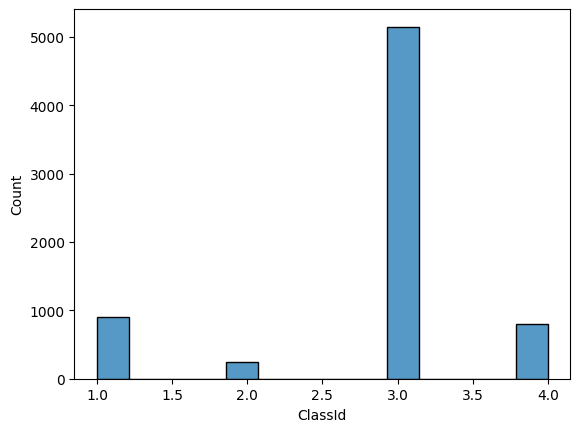

In [9]:
sns.histplot(train_lbls, x='ClassId')


In [10]:
weights = torch.zeros(5)
for cls in train_lbls['ClassId'].unique():
    _cls = train_lbls['ClassId'] == cls
    weights[cls] = _cls.sum()
weights =   F.sigmoid(weights.max() / weights)
weights[0] = weights.min()
weights


tensor([0.7311, 0.9968, 1.0000, 0.7311, 0.9984])

<br>

**Data Preprocessing**

Defect class: 3


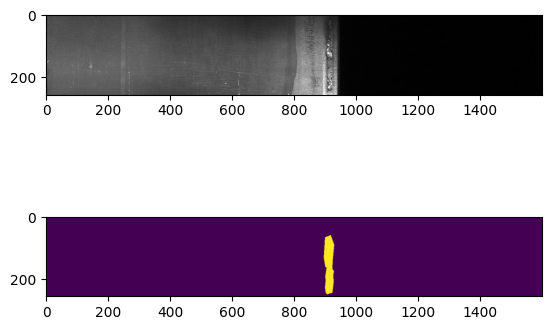

In [11]:
def get_sample(index, workdir, labels):
    sample = labels.iloc[index]
    sample_name = sample['ImageId']
    sample_class = sample['ClassId']
    sample_coords = np.array(sample['EncodedPixels'].split(), dtype=int)
    sample_img = cv.imread(f'{workdir}{sample_name}')

    return sample_img, sample_coords, sample_class

def resize(image, shape, interpolation=cv.INTER_AREA):
    resized_image = cv.resize(image, shape, interpolation=interpolation)
    return resized_image


def make_mask(index, workdir, labels, n_classes=4):
    sample_img, sample_coords, sample_class = get_sample(index, workdir, labels)
    sample_mask = np.zeros_like(sample_img[:, :, 0].flatten(), dtype=np.int8)
    coord = sample_coords[::2]
    run_len = sample_coords[1::2]

    for _coord, _len in zip(coord, run_len):
        sample_mask[_coord: _coord+_len] = 1

    _mask = sample_mask.reshape(sample_img.shape[:2], order='F')
    sample_mask = np.zeros((n_classes+1, sample_img.shape[0],sample_img.shape[1]))
    sample_mask[sample_class] = _mask
    sample_mask[0] = 1 - _mask

    return sample_img, sample_mask, sample_class
sample_img, sample_mask, sample_class = make_mask(4, image_train_dir, train_lbls)

fig, axs = plt.subplots(2)

axs[0].imshow(sample_img)
axs[1].imshow(sample_mask[sample_class])
print(f"Defect class: {sample_class}")


<br>

**Dataset and DataLoader configuration**

In [12]:
class SteelDefectDataset(Dataset):
    def __init__(self, datalist, image_dir, it_has_mask=True, shape=(512, 128)):

        self.image_dir = image_dir
        self.datalist = datalist
        self.mask = it_has_mask
        classes = datalist['ClassId'].unique()
        self.n_class = len(classes)
        if shape:
            self.shape = shape
        else:
            self.shape = False

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        if self.mask:
            image, mask, cls = make_mask(idx, self.image_dir, self.datalist)
            if self.shape:
                image = resize(image, self.shape)
                _m = np.zeros((5, self.shape[1], self.shape[0]))
                _m[cls] = resize(mask[cls].astype(float), self.shape)
                mask = _m
                mask[0] = 1 - _m[cls]
            return image, mask, cls

        else:
            image, _, cls = get_sample(idx, self.image_dir, self.datalist)
            if self.shape:
                image = resize(image, self.shape)

            return image, self.datalist.iloc[idx]['ImageId']

    def show(self, idx):
        if self.mask:
            sample_img, sample_mask, cls = self[idx]
            fig, axs = plt.subplots(2)
            axs[0].imshow(sample_img)
            axs[1].imshow(sample_mask[cls])
        else:
            sample_img, cls = self[idx]
            plt.imshow(sample_img)
        print(f"Defect class: {cls}")


In [13]:
torch.manual_seed(42)

train_ds = SteelDefectDataset(train_lbls, image_train_dir)
validate_ds = SteelDefectDataset(val_lbls, image_val_dir, it_has_mask=False)

train_size = int(len(train_ds)*0.9)
test_size = len(train_ds) - train_size

train_set, test_set = random_split(train_ds, [train_size, test_size])

data_loader_train = DataLoader(train_set, batch_size=8, shuffle=False)
data_loader_test = DataLoader(test_set, batch_size=1, shuffle=False)
data_loader_validate = DataLoader(validate_ds, batch_size=1, shuffle=False)


Defect class: 3


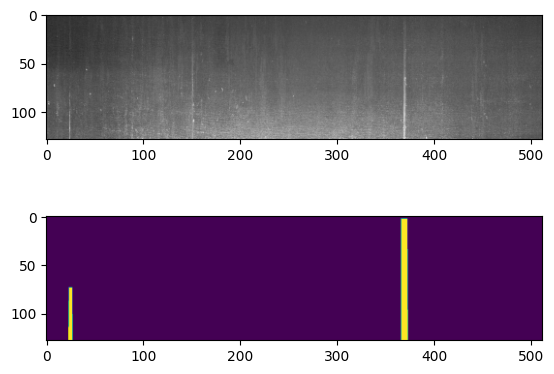

In [14]:
train_ds.show(1)


Defect class: 0000f269f.jpg


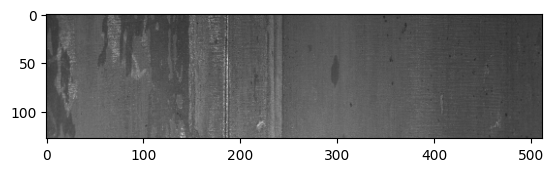

In [15]:
validate_ds.show(0)


<br>

**Model Design**

In [16]:
class Conv2DLayer(nn.Module):
    def __init__(self, in_layers, out_layers, pooling_stride=2):
        super().__init__()

        self.stack = nn.Sequential(
                nn.Conv2d(in_layers, out_layers, kernel_size=3, padding=1, stride=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_layers, out_layers, kernel_size=3, padding=1, stride=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=pooling_stride, stride=pooling_stride)
            )

    def forward(self, x):
        return self.stack(x)


class UpScaleX2(nn.Module):
    def __init__(self, in_layers, out_layers, skip_con_layers=0, padding=None):
        super().__init__()
        self.padding = padding
        self.transpose = nn.ConvTranspose2d(in_layers, in_layers, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upscale_stack = nn.Sequential(
            nn.Conv2d(in_layers + skip_con_layers, out_layers, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_layers, out_layers, kernel_size=3, padding=1, stride=1), nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2=None):

        x1 = self.transpose(x1)

        if self.padding is not None:
            x1 = F.pad(x1, self.padding)

        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        y = self.upscale_stack(x)

        return y



class DefectDetectionNet(nn.Module):
    def __init__(self, init_count=64, color_channels=3, n_classes=2):
        super().__init__()

        self.ch_init = init_count

        # Encoder:
        self.l_in = Conv2DLayer(color_channels, self.ch_init)
        self.l_1 = Conv2DLayer(self.ch_init, 2 * self.ch_init)
        self.l_2 = Conv2DLayer(2 * self.ch_init, 4 * self.ch_init)
        self.l_3 = Conv2DLayer(4 * self.ch_init, 8 * self.ch_init)
        self.l_4 = Conv2DLayer(8 * self.ch_init, 16 * self.ch_init)

        # Decoder:
        self.l_trans_5 = UpScaleX2(16 * self.ch_init, 8 * self.ch_init, skip_con_layers=8 * self.ch_init)
        self.l_trans_6 = UpScaleX2(8 * self.ch_init, 4 * self.ch_init, skip_con_layers=4 * self.ch_init)
        self.l_trans_7 = UpScaleX2(4 * self.ch_init, 2 * self.ch_init, skip_con_layers=2 * self.ch_init)
        self.l_trans_8 = UpScaleX2(2 * self.ch_init, self.ch_init, skip_con_layers=1 * self.ch_init)
        self.l_trans_9 = UpScaleX2(self.ch_init, self.ch_init//2, skip_con_layers=3)

        self.final_conv = nn.Conv2d(self.ch_init//2, n_classes, kernel_size=1, stride=1)


    def forward(self, x, training=False):

        y1 = self.l_in(x)
        y2 = self.l_1(y1)
        y3 = self.l_2(y2)
        y4 = self.l_3(y3)
        y = self.l_4(y4)

        y = self.l_trans_5(y, y4)
        y = self.l_trans_6(y, y3)
        y = self.l_trans_7(y, y2)
        y = self.l_trans_8(y, y1)
        y = self.l_trans_9(y, x)
        y = self.final_conv(y)
        return F.relu(y)

    def predict(self, x, threshold=0.5):

        logits = self(x)
        prediction = F.softmax(logits, dim=1)
        return (prediction > threshold).int()


<br>

**Model configuration**

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

model = DefectDetectionNet(64, 3, train_ds.n_class+1).to(device)
metric = Dice(num_classes=5, ignore_index=0).to(device)
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
epochs = 5


Using cuda device


<br>

**Model training**

In [18]:
def train(dataset, model, loss_fn, optimizer,  device, b_size=10):
    size = len(dataset.dataset)
    model.train()
    losses = []
    for batch, (X, y, c) in enumerate(dataset):
        torch.cuda.empty_cache()
        print(batch, end='\r')
        X, y = X.to(device), y.to(device)

        logits = model(X.float().permute(0,3,1,2))
        loss = loss_fn(logits, y)
        losses.append(loss)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % b_size == 0:
            loss, current = loss.item(), (batch) * len(X)
            print(f"{time.ctime()} - loss: {torch.mean(torch.tensor(losses))}  [{current:>5d}/{size:>5d}]")
            losses = []

def test(dataset, model, metric, device):
    size = len(dataset.dataset)
    model.eval()
    metric_val, correct = 0, 0
    with torch.no_grad():
        for X, y, c in dataset:
            X, y = X.to(device), y.to(device)
            pred = model.predict(X.float().permute(0,3,1,2))
            m_el = metric(pred[0], y[0].int())
            metric_val += m_el.item()
    metric_val /= size
    print(f"Test Error: Avg Metric value: {metric_val} \n")
    torch.cuda.empty_cache()
    return metric_val

Epoch: 1 of 5
Tue Feb 18 15:43:04 2025 - loss: 1.297300466479137  [    0/ 6385]
Tue Feb 18 15:44:05 2025 - loss: 0.47570191232171644  [ 1200/ 6385]
Tue Feb 18 15:45:09 2025 - loss: 0.3163872859200232  [ 2400/ 6385]
Tue Feb 18 15:46:14 2025 - loss: 0.2853229474304501  [ 3600/ 6385]
Tue Feb 18 15:47:19 2025 - loss: 0.293980721979537  [ 4800/ 6385]
Tue Feb 18 15:48:24 2025 - loss: 0.2496712738602422  [ 6000/ 6385]
Test Error: Avg Metric value: 0.9432362120755962 

Epoch: 2 of 5
Tue Feb 18 15:49:11 2025 - loss: 0.19643850411717317  [    0/ 6385]
Tue Feb 18 15:50:16 2025 - loss: 0.26617279832738533  [ 1200/ 6385]
Tue Feb 18 15:51:20 2025 - loss: 0.2325787146687303  [ 2400/ 6385]
Tue Feb 18 15:52:25 2025 - loss: 0.2232993121891068  [ 3600/ 6385]
Tue Feb 18 15:53:30 2025 - loss: 0.20374277296720208  [ 4800/ 6385]
Tue Feb 18 15:54:35 2025 - loss: 0.17728243095769353  [ 6000/ 6385]
Test Error: Avg Metric value: 0.9504986501915355 

Epoch: 3 of 5
Tue Feb 18 15:55:20 2025 - loss: 0.12643945133591

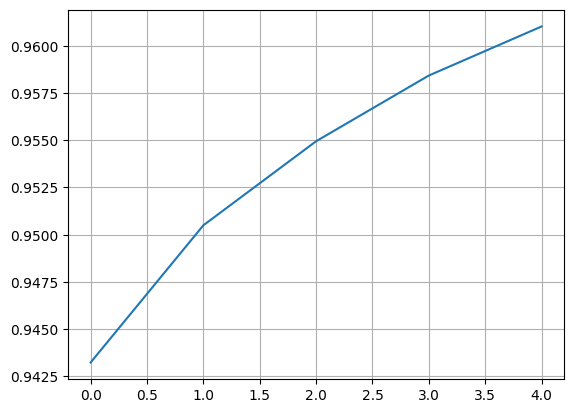

In [19]:
metrics = []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1} of {epochs}')
    train(data_loader_train, model, loss_fn, optimizer, device=device, b_size=150)
    metrics.append(test(data_loader_test, model, metric, device=device))
plt.plot(metrics)
plt.grid()


<br>

**Model testing**

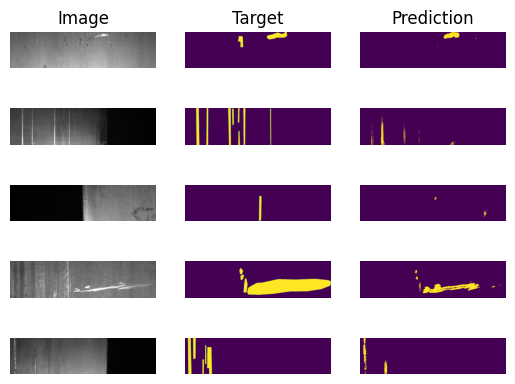

In [20]:
fig, axs = plt.subplots(5,3)
axs[0, 0].set_title("Image")
axs[0, 1].set_title("Target")
axs[0, 2].set_title("Prediction")

for i, batch in enumerate(data_loader_test):
    X, y, c = batch
    c = c[0]
    axs[i, 0].imshow(X[0])
    X = X.to(device)
    with torch.no_grad():
        y_hat = model.predict(X.permute(0, 3, 1,2).float()).cpu()
    axs[i, 1].imshow(y[0][c])
    axs[i, 2].imshow(y_hat[0][c])
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    if i == 4:
        break


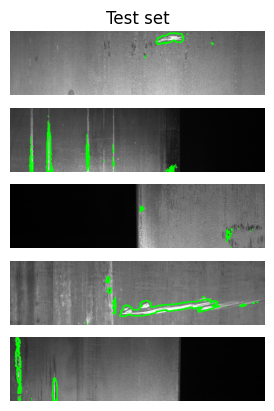

In [21]:
def draw_contures(img, mask, cls):
    colors = ((255,0,0), (0,255,0),(0,255,0),(255,255,0))

    contours, hierarchy = cv.findContours(mask[cls].astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img = cv.drawContours(img, contours, -1, colors[c-1], 2)
    return img

fig, axs = plt.subplots(5)
axs[0].set_title("Test set")

for i, batch in enumerate(data_loader_test):
    X, y, c = batch
    c = c[0]
    X = X.to(device)
    with torch.no_grad():
        y_hat = model.predict(X.permute(0, 3, 1,2).float()).cpu()[0]
    classes = np.where(np.array([Y.max() for Y in y_hat.numpy()])>0)[0]
    img = X.cpu().numpy()[0]
    for cls in classes[1:]:
        img = draw_contures(img, y_hat.numpy(), c)

    axs[i].imshow(img)
    axs[i].axis('off')

    if i == 4:
        break

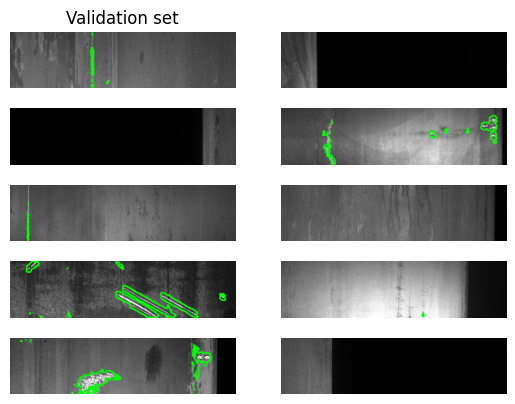

In [22]:
from statistics import mode
fig, axs = plt.subplots(5,2)
axs[0,0].set_title("Validation set")

for i, batch in enumerate(data_loader_validate):
    X, c = batch

    X = X.to(device)
    with torch.no_grad():
        y_hat = model.predict(X.permute(0, 3, 1,2).float()).cpu()[0]
    if y_hat[1:].max()>0:
        c = mode(np.where(y_hat[1:]>0)[0]) + 1
        axs[i%5, i//5].imshow(draw_contures(X.cpu().numpy()[0], y_hat.numpy(), c))

    else:
        axs[i%5, i//5].imshow(X.cpu().numpy()[0])

    axs[i%5, i//5].axis('off')

    if i == 9:
        break


In summary, the model is able to correctly detect the defects in steel sheets with an accuracy of 96%.